# Face detection with IceVision, Neural Magic and Amazon SageMaker

Dataset: we will use 1k randomly sampled images from the [WiderFace dataset](http://shuoyang1213.me/WIDERFACE/index.html)

## Training a model with IceVision

In [ ]:
from icevision.all import *

#### Custom data parser

In [2]:
import scipy.io
import os
import pandas as pd

class FaceParser(Parser):
    def __init__(self, template_record, data_dir, anns_file):
        super().__init__(template_record=template_record)
        
        self.data_dir = data_dir
        self.anns = scipy.io.loadmat(anns_file)

        folders = [x[0].split('--')[1] for x in os.walk(data_dir) if '--' in x[0] and 'people' not in x[0]]
        folders.sort()
        files = [n[0][0] for f in self.anns["file_list"] for n in f[0]]
        boxes = [n[0] for f in self.anns["face_bbx_list"] for n in f[0]]
        invalid = [n[0] for f in self.anns["invalid_label_list"] for n in f[0]]
        self.df = pd.DataFrame({"filename": files, "bbox": boxes, "invalid": invalid})
        self.df["directory"] = self.df.filename.apply(lambda x: x.split("_")[0]+"--"+self.get_folder(x, folders))
        self.df = self.df.sample(1000, random_state=0)

        self.class_map = ClassMap(["face"])

    def get_folder(self, s, folders):
        for f in folders:
            if f in s:
                return f    
        return 'people--driving--car'

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.filename

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_img_size(self.data_dir / o.directory / (o.filename+".jpg"))

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / o.directory / (o.filename+".jpg"))
            record.set_img_size(self.image_width_height(o))
            record.detection.set_class_map(self.class_map)

        for box, invalid in zip(o.bbox, o.invalid):
            if invalid[0] == 0:
                record.detection.add_bboxes([BBox.from_xywh(*box)])
                record.detection.add_labels(["face"])

#### Parsing the data and visualizing records

In [3]:
template_record = ObjectDetectionRecord()
data_dir = Path('/home/ubuntu/data/WIDER_train/images')
anns_file = Path('/home/ubuntu/data/wider_face_split/wider_face_train.mat')
parser = FaceParser(template_record, data_dir, anns_file)

train_records, valid_records = parser.parse()

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/1000 [00:00<?, ?it/s]

AUTOFIX-FAIL - (record_id: 36_Football_Football_36_63) - Cannot auto-fix coordinates: <BBox (xmin:713, ymin:34, xmax:714, ymax:34)>
	y_min:34 is greater than or equal to y_max:34 | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-REPORT - (record_id: 36_Football_Football_36_63) Removed annotation with index: 4, for more info check the AUTOFIX-FAIL messages above | icevision.core.record:autofix:45
AUTOFIX-FAIL - (record_id: 2_Demonstration_Demonstrators_2_373) - Cannot auto-fix coordinates: <BBox (xmin:770, ymin:3, xmax:770, ymax:4)>
	x_min:770 is greater than or equal to x_max:770 | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-REPORT - (record_id: 2_Demonstration_Demonstrators_2_373) Removed annotation with index: 10, for more info check the AUTOFIX-FAIL messages above | icevision.core.record:autofix:45


In [4]:
len(train_records), len(valid_records)

(800, 200)

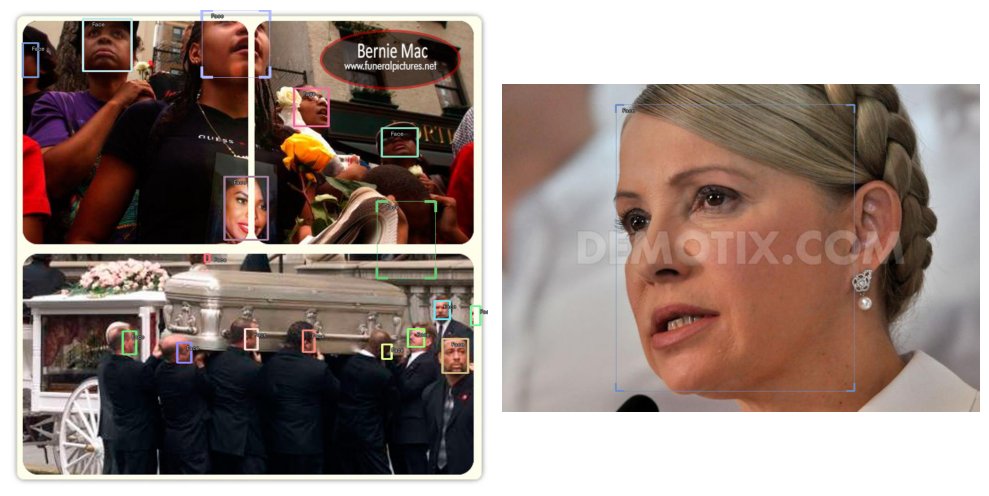

In [5]:
show_records(random.sample(list(valid_records), 2), class_map=parser.class_map, ncols=2, figsize=(10, 10))

#### Image transforms, datasets and dataloaders

In [6]:
presize = 960
size = 768

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize, shift_scale_rotate=None), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

len(train_ds), len(valid_ds)

(800, 200)

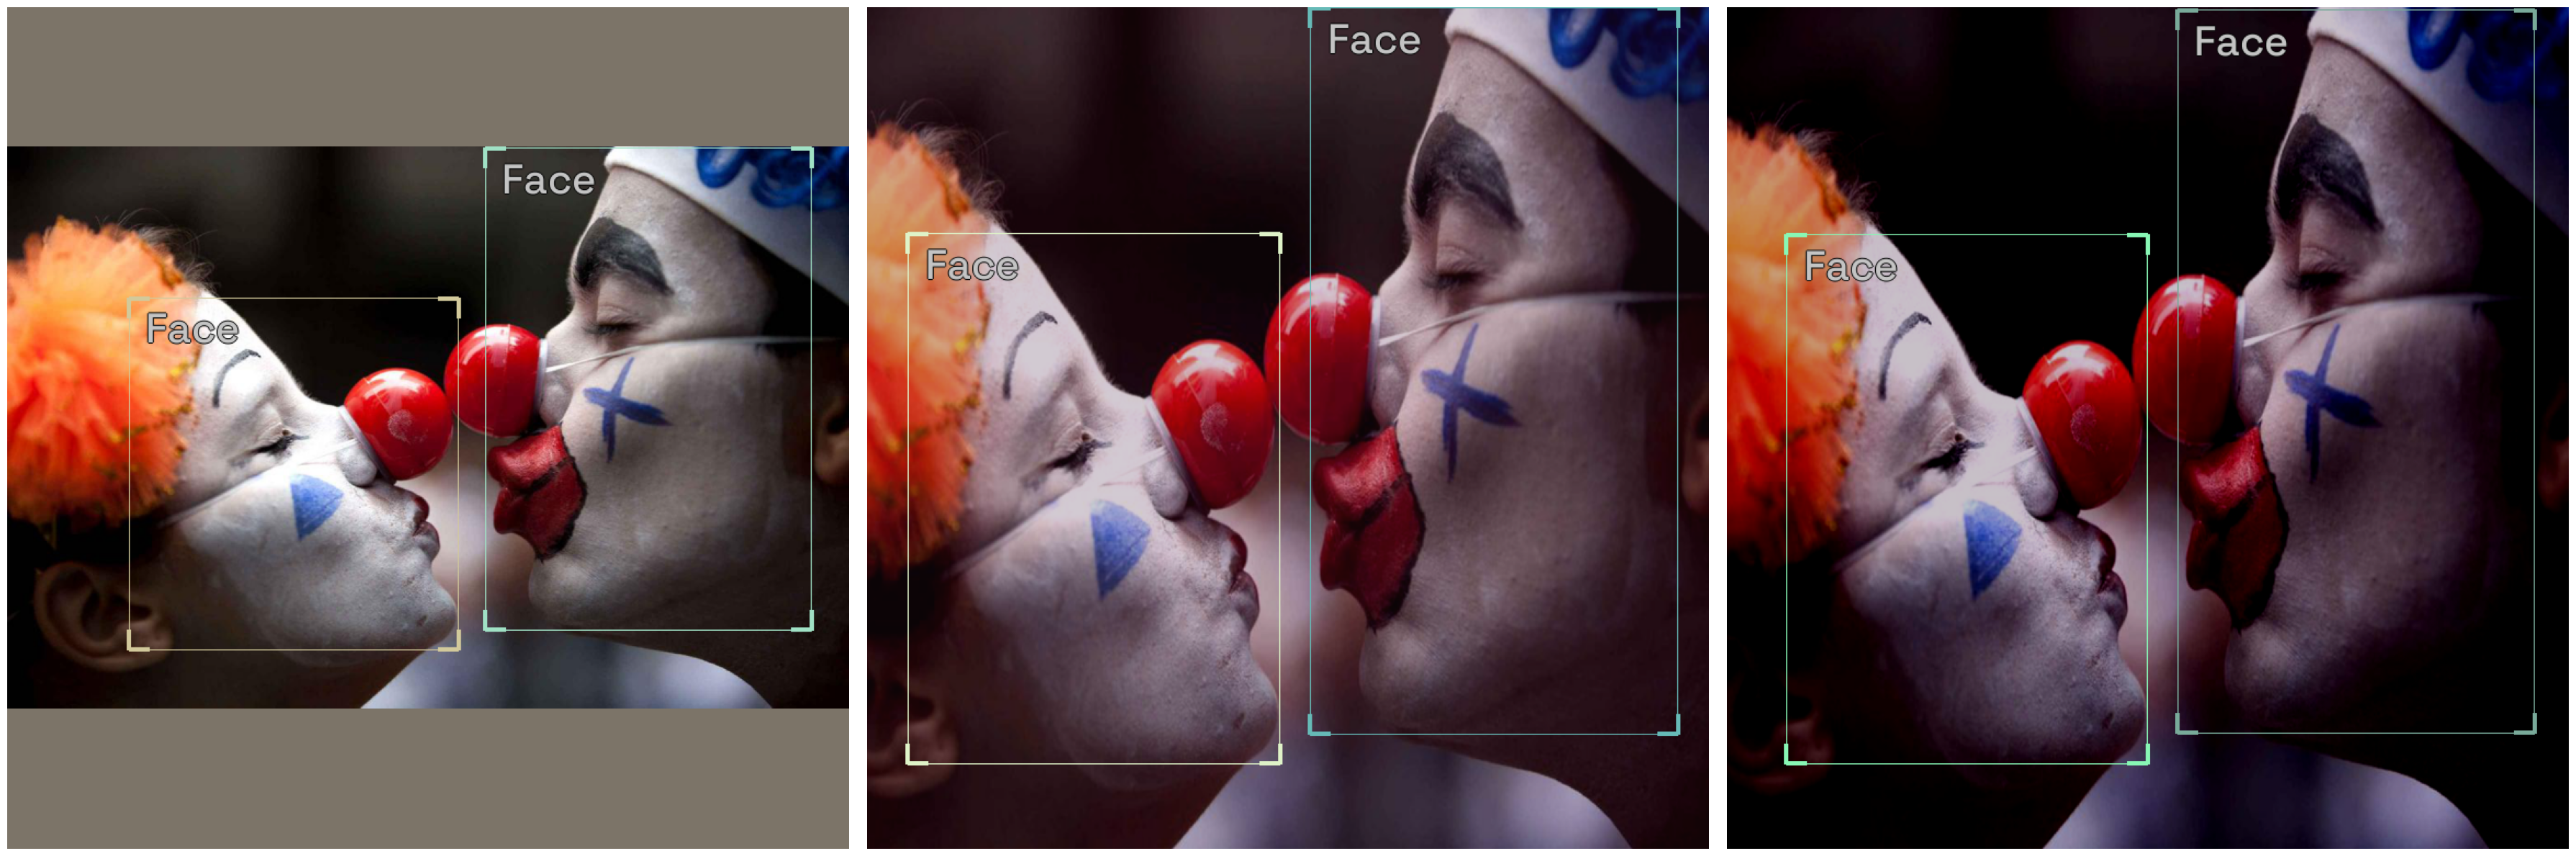

In [8]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[1] for _ in range(3)]
show_samples(samples, ncols=3)

#### YoloV5 small

In [11]:
model_type = models.ultralytics.yolov5

In [ ]:
bs = 24
train_dl = model_type.train_dl(train_ds, batch_size=bs, num_workers=8, shuffle=False)
valid_dl = model_type.valid_dl(valid_ds, batch_size=bs, num_workers=8, shuffle=False)

In [13]:
(x, y), recs = first(train_dl)
x.shape, y.shape

(torch.Size([24, 3, 768, 768]), torch.Size([394, 6]))

In [20]:
# dl = model_type.valid_dl(valid_ds, batch_size=2, num_workers=2, shuffle=False)
# batch = first(dl)
# model_type.show_batch(batch, ncols=2)

In [ ]:
backbone = model_type.backbones.small(pretrained=True)

model = model_type.model(backbone=backbone, 
                         num_classes=parser.class_map.num_classes, 
                         img_size=size, 
                         device=torch.device("cuda"))

#### Training the model

In [15]:
from fastai.callback.tracker import SaveModelCallback

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
cbs = SaveModelCallback(monitor='COCOMetric', fname="yolo_small_ice")

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=cbs)

SuggestedLRs(valley=0.004365158267319202)

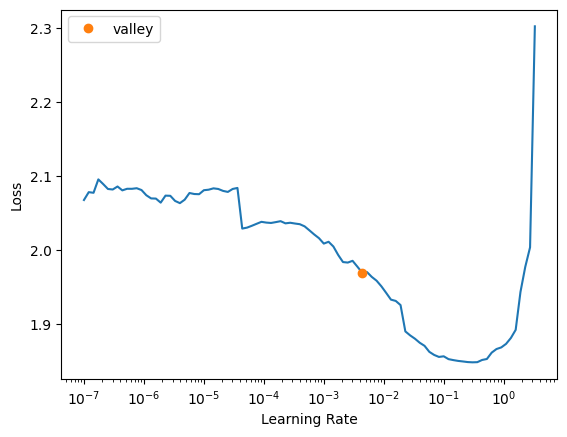

In [24]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(20, 5e-3)

/home/ubuntu/anaconda3/envs/ice/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Better model found at epoch 0 with COCOMetric value: 0.00032827173670422116.
Better model found at epoch 1 with COCOMetric value: 0.0012660955956364656.
Better model found at epoch 2 with COCOMetric value: 0.017346710852599246.
Better model found at epoch 3 with COCOMetric value: 0.0443883904259901.
Better model found at epoch 4 with COCOMetric value: 0.13297908351068255.
Better model found at epoch 6 with COCOMetric value: 0.21278036129565547.
Better model found at epoch 7 with COCOMetric value: 0.22057283888204482.
Better model found at epoch 8 with COCOMetric value: 0.26190796971055436.
Better model found at epoch 9 with COCOMetric value: 0.2662939234958904.
Better model found at epoch 10 with COCOMetric value: 0.27953893119205775.
Better model found at epoch 11 with COCOMetric value: 0.3081039045403979.
Better model found at epoch 12 with COCOMetric value: 0.33250618824028166.
Better model found at epoch 13 with COCOMetric value: 0.3612973948131856.
Better model found at epoch 14 w

#### Testing the model on Francesco's faces :) 

In [2]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(768), tfms.A.Normalize()])

import PIL
def get_image(p): return np.array(PIL.Image.open(p))

imgs = random.sample([get_image(f"./testfaces/fraface{i}.jpeg") for i in range(1, 8)], 4)

In [ ]:
model_type = models.ultralytics.yolov5
backbone = model_type.backbones.small(pretrained=True)
model = model_type.model(backbone=backbone, num_classes=2, 
                         img_size=768, device=torch.device("cpu"))

model.load_state_dict(torch.load('./models/yolo_small_ice.pth', map_location=torch.device('cpu')))

/home/ubuntu/anaconda3/envs/ice/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


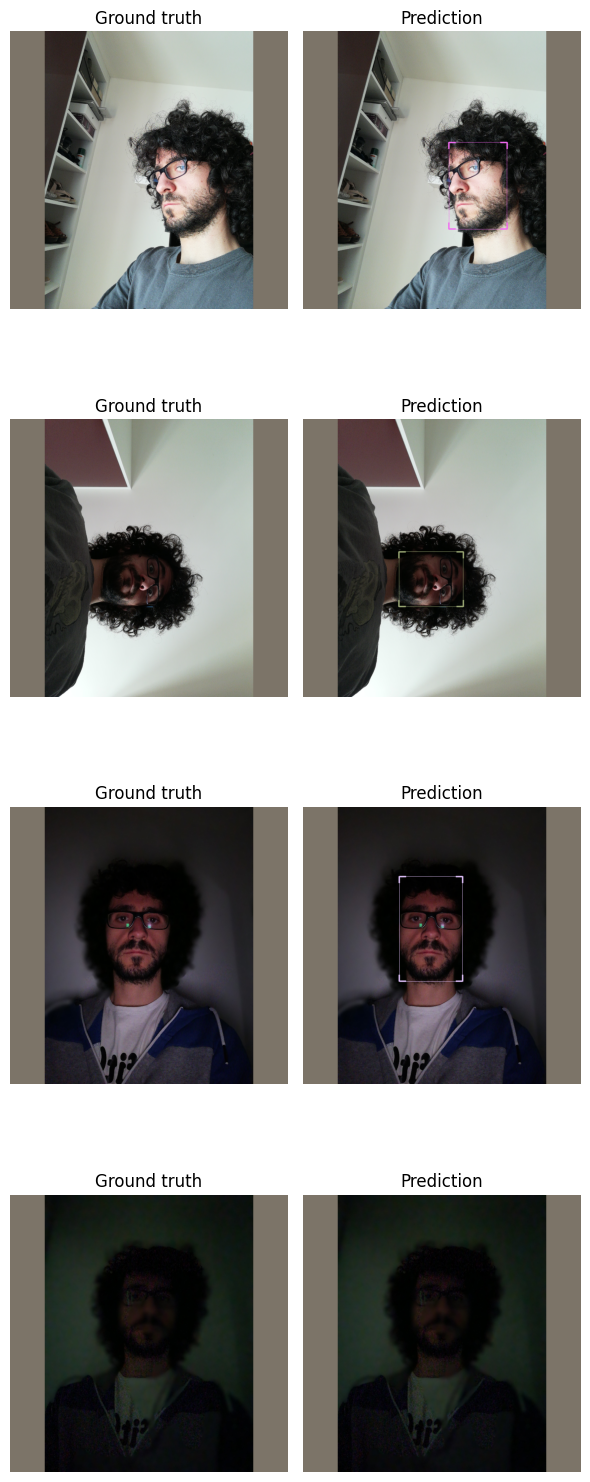

In [12]:
infer_ds = Dataset.from_images(imgs, infer_tfms)
preds = model_type.predict(model, infer_ds, keep_images=True)
show_preds(preds=preds)

#### Checking latency

In [14]:
pred_dict  = model_type.end2end_detect("./testfaces/fraface1.jpeg",
                                       infer_tfms, model, class_map=ClassMap(['face']),
                                       return_img=False)
pred_dict

{'detection': {'scores': array([    0.67063], dtype=float32),
  'bboxes': [<BBox (xmin:1212, ymin:1332, xmax:2268, ymax:2862)>],
  'labels': ['face'],
  'label_ids': [1]},
 'img': None,
 'width': 4608,
 'height': 3456}

In [6]:
model = model.to(torch.device("cpu"))
next(model.parameters()).is_cuda

False

In [7]:
%%timeit
with torch.inference_mode(): 
    _  = model_type.end2end_detect("./testfaces/fraface1.jpeg", infer_tfms, model, class_map=ClassMap(['face']), return_img=False)

/home/ubuntu/anaconda3/envs/ice/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


537 ms ± 6.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Training a model with Neural Magic

#### Preparing the data
We are going to create the [folder structure](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data#11-create-datasetyaml) needed to train a YoloV5 model from Ultralytics with the exact same images we used for IceVision

In [ ]:
import shutil

base_path = Path('/home/ubuntu/data/neuralmagic_faces')

for split in ["train", "valid"]:
    for fold in ["images", "labels"]:
        (base_path / split / fold).mkdir(parents=True, exist_ok=True)


def save_img_and_label(rec, split):
    try:
        img_w, img_h, orig_fname = rec.common.width, rec.common.height, rec.filepath
        img_fname = base_path / split / "images" / rec.filepath.name
        label_fname = base_path / split / "labels" / (rec.filepath.stem+".txt")
        shutil.copyfile(orig_fname, img_fname)

        labels = []
        for bbox in rec.detection.bboxes: labels.append((0, *bbox.relative_xcycwh(img_w, img_h)))

        pd.DataFrame(labels).to_csv(label_fname, sep=" ", index=False, header=None)
        with open(label_fname, 'r+') as f:
            f.seek(0,2)                    
            size=f.tell()               
            f.truncate(size-1)

        return img_fname, label_fname, labels
    except:
        print(rec)

for rec in train_records: _ = save_img_and_label(rec, "train")
for rec in valid_records: _ = save_img_and_label(rec, "valid")

In [3]:
!ls /home/ubuntu/data/neuralmagic_faces/train/images/ | wc -l
!ls /home/ubuntu/data/neuralmagic_faces/train/labels/ | wc -l

!ls /home/ubuntu/data/neuralmagic_faces/valid/images/ | wc -l
!ls /home/ubuntu/data/neuralmagic_faces/valid/labels/ | wc -l

800
800
200
200


#### Training

Then we apply a [sparse transfer learning](https://github.com/neuralmagic/sparseml/tree/main/integrations/ultralytics-yolov5) recipe from the Neural Magic zoo, pointing it to the `faces_data.yaml` file containing our dataset definitions.

```
sparseml.yolov5.train \
  --data faces_data.yaml \
  --cfg models_v5.0/yolov5s.yaml \
  --weights zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned_quant-aggressive_94?recipe_type=transfer \
  --hyp data/hyps/hyp.finetune.yaml \
  --recipe zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned_quant-aggressive_94?recipe_type=transfer_learn \
  --project neural_magic --name yolov5s_pruned_quant-aggressive_94
```
We can follow the training in real time on [W&B](https://wandb.ai/frapochetti/neural_magic/runs/2t8npx2c?workspace=user-frapochetti) too!

#### Converting to ONNX

Once done, we convert the `best.pt` weights (saved automatically by Neural Magic) to ONNX, to be able to use the DeepSparse engine for inference.

```
sparseml.yolov5.export_onnx \
 --weights ~/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.pt \
 --dynamic
```

#### Inference with the `deepsparse` CLI

Let's try running inference with the `deepsparse` CLI now...

In [1]:
!deepsparse.object_detection.annotate --source ./testfaces/fraface7.jpeg --model_filepath ~/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.onnx

2022-08-21 12:46:36 deepsparse.utils.annotate INFO     Results will be saved to annotation-results/deepsparse-annotations
DeepSparse Engine, Copyright 2021-present / Neuralmagic, Inc. version: 1.0.2 (7dc5fa34) (release) (optimized) (system=avx512, binary=avx512)
2022-08-21 12:46:46 deepsparse.yolo.annotate INFO     Results saved to annotation-results/deepsparse-annotations


... which produces the following `result-0.jpg` annotated file.

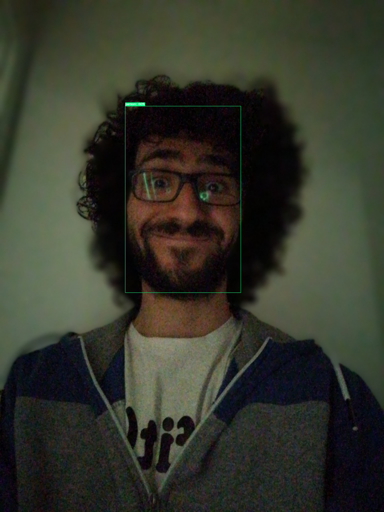

In [3]:
from PIL import Image

img = Image.open("./annotation-results/deepsparse-annotations/result-0.jpg")
img.thumbnail((512, 512))
img

#### Inference with [DeepSparse Pipelines](https://github.com/neuralmagic/deepsparse/tree/main/src/deepsparse/yolo)

In [5]:
from deepsparse.cpu import cpu_vnni_compatible
print(f"VNNI available: {cpu_vnni_compatible()}")

VNNI available: True


In [6]:
import PIL
import numpy as np
import cv2

def draw_bbox(img, xyxy):
    draw = PIL.ImageDraw.Draw(img)

    w, h = img.size
    scale_y = h / 640.
    scale_x = w / 640.

    left = int(xyxy[0] * scale_x)
    top = int(xyxy[1] * scale_y)
    right = int(xyxy[2] * scale_x)
    bottom = int(xyxy[3] * scale_y)

    # bbox thickness of bboxes without corners
    min_bbox = 1
    max_bbox = 8
    bbox_thickness = int(0.0041 * h - 0.0058)
    if bbox_thickness < min_bbox:
        bbox_thickness = min_bbox
    if bbox_thickness > max_bbox:
        bbox_thickness = int(max_bbox)

    draw.rectangle((left, top, right, bottom), fill=None, outline="greenyellow", width=bbox_thickness)
    return img

def load_image(img, image_size = (640, 640)):
    img = cv2.imread(img) if isinstance(img, str) else img
    img_resized = cv2.resize(img, image_size)
    img_transposed = img_resized[:, :, ::-1].transpose(2, 0, 1)

    return img_transposed

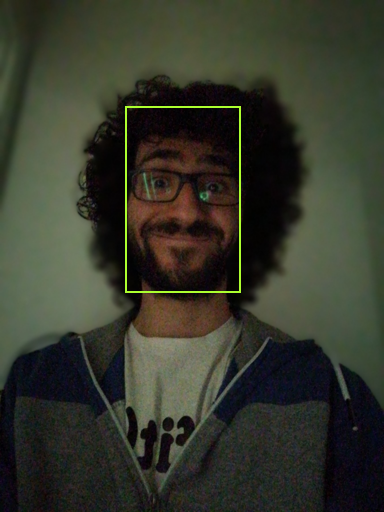

In [8]:
from deepsparse.pipeline import Pipeline

model_stub = "./neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.onnx"
images_paths = ['./testfaces/fraface7.jpeg']
images = [load_image(i) for i in images_paths]

yolo_pipeline = Pipeline.create(
    task="yolo",
    model_path=model_stub,
)

pipeline_outputs = yolo_pipeline(images=images, iou_thres=0.6, conf_thres=0.5)

boxes = pipeline_outputs[0].boxes
scores = pipeline_outputs[0].scores

img = PIL.Image.open(images_paths[0])
img.thumbnail((512, 512))
img = draw_bbox(img, boxes[0])
img

#### Benchmarking

Let's now check overall model performance. 

Given we have aggressively pruned and quantized, we should expect pretty good results.

Keep in mind we are running on a GPU-powered `g4dn.xlarge` EC2 machine, but executing on CPU.

In [1]:
!deepsparse.benchmark ~/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.onnx --scenario async

2022-08-21 13:58:04 deepsparse.benchmark.benchmark_model INFO     Thread pinning to cores enabled
DeepSparse Engine, Copyright 2021-present / Neuralmagic, Inc. version: 1.0.2 (7dc5fa34) (release) (optimized) (system=avx512, binary=avx512)
2022-08-21 13:58:08 deepsparse.benchmark.benchmark_model INFO     num_streams default value chosen of 2. This requires tuning and may be sub-optimal
2022-08-21 13:58:08 deepsparse.benchmark.benchmark_model INFO     deepsparse.engine.Engine:
	onnx_file_path: /home/ubuntu/KagglePlaygrounds/neuralmagic_faces/neural_magic/yolov5s_pruned_quant-aggressive_94/weights/best.onnx
	batch_size: 1
	num_cores: 4
	num_streams: 0
	scheduler: Scheduler.multi_stream
	cpu_avx_type: avx512
	cpu_vnni: True
2022-08-21 13:58:08 deepsparse.utils.onnx INFO     Generating input 'input', type = uint8, shape = [1, 3, 640, 640]
2022-08-21 13:58:08 deepsparse.benchmark.benchmark_model INFO     Starting 'multistream' performance measurements for 10 seconds
Original Model Path: /hom

## Deploying the Neural Magic model to Amazon SageMaker with a custom Docker container

We have copied the `best.onnx` file generated by Neural Magic to `./opt/ml/model` to respect the folder's structure SageMaker asks for in production.

You can find all the details of the process in this ADD LINK blog post of mine. In here I'll just go through the basic steps to deploy the model.

In [ ]:
!cd KagglePlaygrounds/neuralmagic_faces/sagemaker_deploy/opt/ml/model/
!tar -cvpzf model.tar.gz best.onnx

Dockerfile

```
FROM python:3.9

RUN apt-get update
RUN apt-get install ffmpeg libsm6 libxext6  -y

RUN pip install opencv-python-headless==4.6.0.66
RUN pip install deepsparse[yolo]==1.0.2   
RUN pip install flask

WORKDIR /usr/local/bin
COPY serve /usr/local/bin/serve

EXPOSE 8080
```

build_and_push_to_ecr.sh

```
TAG="neuralmagic"
IMAGE_URI="custom-images"
ACCOUNT_ID=$(aws sts get-caller-identity --query "Account" --output text)
REGION="eu-west-1"

docker build -t $TAG .
aws ecr get-login-password --region $REGION | docker login --username AWS --password-stdin $ACCOUNT_ID.dkr.ecr.$REGION.amazonaws.com
docker tag $TAG:latest $ACCOUNT_ID.dkr.ecr.$REGION.amazonaws.com/$IMAGE_URI:$TAG
docker push $ACCOUNT_ID.dkr.ecr.$REGION.amazonaws.com/$IMAGE_URI:$TAG
```

In [ ]:
!./sagemaker_deploy/build_and_push_to_ecr.sh

In [6]:
import boto3, sagemaker

region = "eu-west-1"
sm_client = boto3.client(service_name="sagemaker", region_name=region)
runtime_sm_client = boto3.client("sagemaker-runtime", region_name=region)
session = sagemaker.Session(boto_session=boto3.Session(region_name=region))
role = "IAM Role with SageMaker permissions"
ecr_image = "257446244580.dkr.ecr.eu-west-1.amazonaws.com/custom-images:neuralmagic"

In [3]:
default_bucket = session.default_bucket()
print(default_bucket)

sagemaker-eu-west-1-257446244580


In [4]:
model_uri = session.upload_data(path="/home/ubuntu/KagglePlaygrounds/neuralmagic_faces/sagemaker_deploy/opt/ml/model/model.tar.gz", key_prefix="neural_magic")
print(model_uri)

s3://sagemaker-eu-west-1-257446244580/neural_magic/model.tar.gz


In [7]:
model = sagemaker.model.Model(image_uri=ecr_image,
                              name="neural-magic",
                              model_data="s3://sagemaker-eu-west-1-257446244580/neural_magic/model.tar.gz",
                              role=role,
                              sagemaker_session=session,
                              predictor_cls=sagemaker.Predictor
                             )

predictor = model.deploy(initial_instance_count=1, 
                         instance_type='ml.m5.large', 
                         endpoint_name="neural-magic")

Using already existing model: neural-magic


------!

In [8]:
session = sagemaker.Session(boto_session=boto3.Session(region_name=region))

predictor = sagemaker.Predictor(endpoint_name='neural-magic', sagemaker_session=session)
predictor

In [9]:
import base64

with open("./testfaces/fraface7.jpeg", "rb") as img_file:
    b64_string = base64.b64encode(img_file.read())

In [10]:
predictor.predict('{"image": "'+b64_string.decode('utf-8')+'"}')

b'{"boxes": [[1127, 955, 2167, 2633]], "scores": [0.5956084728240967]}'

In [ ]:
predictor.delete_endpoint()